In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

In [2]:
def generate_sine_wave_data(samples=1000, time_steps=20):
    """Generate a synthetic sine wave dataset with some noise."""
    # Generate x values
    x = np.linspace(0, 30, samples + time_steps)
    # Generate sine wave with some noise
    y = np.sin(x) + 0.1 * np.random.randn(len(x))

    # Create sequences of time_steps for training
    X, Y = [], []
    for i in range(len(y) - time_steps):
        X.append(y[i:i + time_steps])
        Y.append(y[i + time_steps])

    return np.array(X), np.array(Y)

In [6]:
class RNN:
    def __init__(self, input_size, hidden_size, output_size, learning_rate=0.01):
        """
        Initialize the RNN.

        Args:
            input_size: Size of the input vector
            hidden_size: Size of the hidden layer
            output_size: Size of the output vector
            learning_rate: Learning rate for gradient descent
        """
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.learning_rate = learning_rate

        # Initialize weights with small random values
        # Wxh: weights from input to hidden layer
        self.Wxh = np.random.randn(hidden_size, input_size) * 0.01
        # Whh: weights from hidden to hidden layer (recurrent connections)
        self.Whh = np.random.randn(hidden_size, hidden_size) * 0.01
        # Why: weights from hidden to output layer
        self.Why = np.random.randn(output_size, hidden_size) * 0.01

        # Initialize biases
        self.bh = np.zeros((hidden_size, 1))  # Hidden bias
        self.by = np.zeros((output_size, 1))  # Output bias

    def forward(self, inputs):
        """
        Forward pass of the RNN.

        Args:
            inputs: Array of input vectors with shape [time_steps, input_size]

        Returns:
            Tuple of (outputs, hidden_states)
        """
        # Store hidden states and outputs for backpropagation
        h = np.zeros((inputs.shape[0] + 1, self.hidden_size, 1))
        y = np.zeros((inputs.shape[0], self.output_size, 1))

        # Forward pass
        for t in range(inputs.shape[0]):
            # Reshape input to column vector
            x = inputs[t].reshape(-1, 1)

            # Update hidden state
            h[t+1] = np.tanh(np.dot(self.Wxh, x) + np.dot(self.Whh, h[t]) + self.bh)

            # Calculate output
            y[t] = np.dot(self.Why, h[t+1]) + self.by

        return y, h

    def backward(self, inputs, targets, outputs, hidden_states):
        """
        Backward pass to compute gradients.

        Args:
            inputs: Input sequences
            targets: Target values
            outputs: Outputs from forward pass
            hidden_states: Hidden states from forward pass

        Returns:
            Dictionary of gradients for each parameter
        """
        # Initialize gradients
        dWxh = np.zeros_like(self.Wxh)
        dWhh = np.zeros_like(self.Whh)
        dWhy = np.zeros_like(self.Why)
        dbh = np.zeros_like(self.bh)
        dby = np.zeros_like(self.by)

        # Initialize loss
        loss = 0

        # Backpropagation through time (BPTT)
        dhnext = np.zeros((self.hidden_size, 1))

        # Process the sequence backwards
        for t in reversed(range(len(inputs))):
            # Reshape target to column vector
            target = targets.reshape(-1, 1)

            # Compute MSE loss
            error = outputs[t] - target
            loss += np.sum(error ** 2) / 2

            # Gradients for Why and by
            dWhy += np.dot(error, hidden_states[t+1].T)
            dby += error

            # Gradient at output of hidden state
            dh = np.dot(self.Why.T, error) + dhnext

            # Gradient for tanh
            dhraw = (1 - hidden_states[t+1] ** 2) * dh

            # Gradients for Wxh, Whh, and bh
            dbh += dhraw
            dWxh += np.dot(dhraw, inputs[t].reshape(1, -1))
            dWhh += np.dot(dhraw, hidden_states[t].T)

            # Gradient for the next iteration
            dhnext = np.dot(self.Whh.T, dhraw)

        # Clip gradients to prevent exploding gradients
        for grad in [dWxh, dWhh, dWhy, dbh, dby]:
            np.clip(grad, -5, 5, out=grad)

        return {
            'Wxh': dWxh,
            'Whh': dWhh,
            'Why': dWhy,
            'bh': dbh,
            'by': dby
        }, loss

    def update_params(self, gradients):
        """Update model parameters using gradient descent."""
        self.Wxh -= self.learning_rate * gradients['Wxh']
        self.Whh -= self.learning_rate * gradients['Whh']
        self.Why -= self.learning_rate * gradients['Why']
        self.bh -= self.learning_rate * gradients['bh']
        self.by -= self.learning_rate * gradients['by']

    def train(self, X, y, epochs, batch_size=None):
        """
        Train the RNN model.

        Args:
            X: Input sequences with shape [n_samples, time_steps, input_size]
            y: Target values with shape [n_samples, output_size]
            epochs: Number of training epochs
            batch_size: Size of mini-batches for training

        Returns:
            List of losses per epoch
        """
        losses = []

        # Use all data if batch_size is None
        if batch_size is None:
            batch_size = X.shape[0]

        for epoch in range(epochs):
            epoch_loss = 0

            # Process mini-batches
            for i in range(0, X.shape[0], batch_size):
                batch_X = X[i:i+batch_size]
                batch_y = y[i:i+batch_size]

                batch_loss = 0

                # Process each sequence in the batch
                for j in range(batch_X.shape[0]):
                    # Forward pass
                    outputs, hidden_states = self.forward(batch_X[j])

                    # Backward pass
                    gradients, seq_loss = self.backward(batch_X[j], batch_y[j], outputs, hidden_states)

                    # Update parameters
                    self.update_params(gradients)

                    batch_loss += seq_loss

                epoch_loss += batch_loss / batch_X.shape[0]

            # Average loss for the epoch
            epoch_loss /= (X.shape[0] // batch_size)
            losses.append(epoch_loss)

            if epoch % 10 == 0:
                print(f"Epoch {epoch}, Loss: {epoch_loss:.4f}")

        return losses

    def predict(self, X):
        """
        Make predictions using the trained model.

        Args:
            X: Input sequences with shape [n_samples, time_steps, input_size]

        Returns:
            Predictions with shape [n_samples, output_size]
        """
        predictions = []

        for i in range(X.shape[0]):
            outputs, _ = self.forward(X[i])
            predictions.append(outputs[-1].flatten())

        return np.array(predictions)

In [7]:
def main():
    # Generate synthetic data
    X, y = generate_sine_wave_data(samples=1000, time_steps=20)

    # Reshape X for the RNN input [n_samples, time_steps, input_size=1]
    X = X.reshape(X.shape[0], X.shape[1], 1)
    # Reshape y for the RNN output [n_samples, output_size=1]
    y = y.reshape(y.shape[0], 1)

    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Initialize and train the RNN
    rnn = RNN(input_size=1, hidden_size=50, output_size=1, learning_rate=0.005)
    losses = rnn.train(X_train, y_train, epochs=100, batch_size=32)

    # Evaluate the model
    predictions = rnn.predict(X_test)
    mse = np.mean((predictions - y_test.flatten()) ** 2)
    print(f"Test MSE: {mse:.4f}")

    # Plot training loss
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()

    # Plot predictions vs true values
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.flatten()[:100], label='True Values')
    plt.plot(predictions[:100], label='Predictions')
    plt.title('RNN Predictions vs True Values')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

Epoch 0, Loss: 1.1380
Epoch 10, Loss: 0.8205
Epoch 20, Loss: 0.8164
Epoch 30, Loss: 0.8060
Epoch 40, Loss: 0.7856
Epoch 50, Loss: 0.7835
Epoch 60, Loss: 0.7810
Epoch 70, Loss: 0.7766
Epoch 80, Loss: 0.7638
Epoch 90, Loss: 0.7550
Test MSE: 1.0638


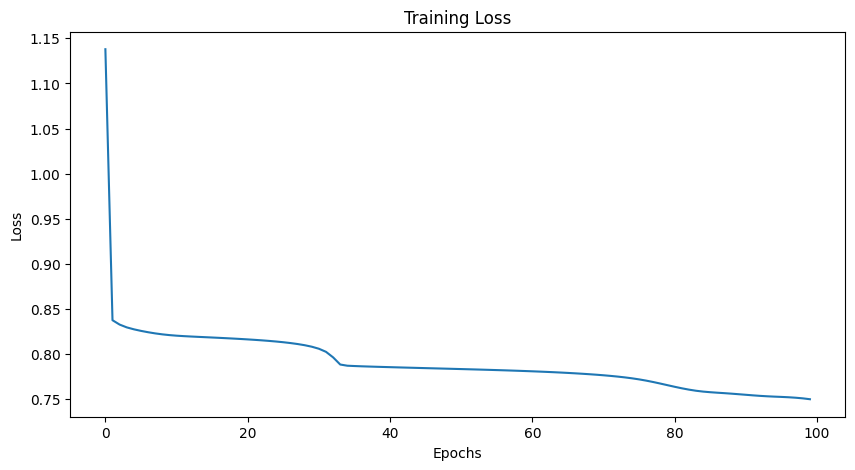

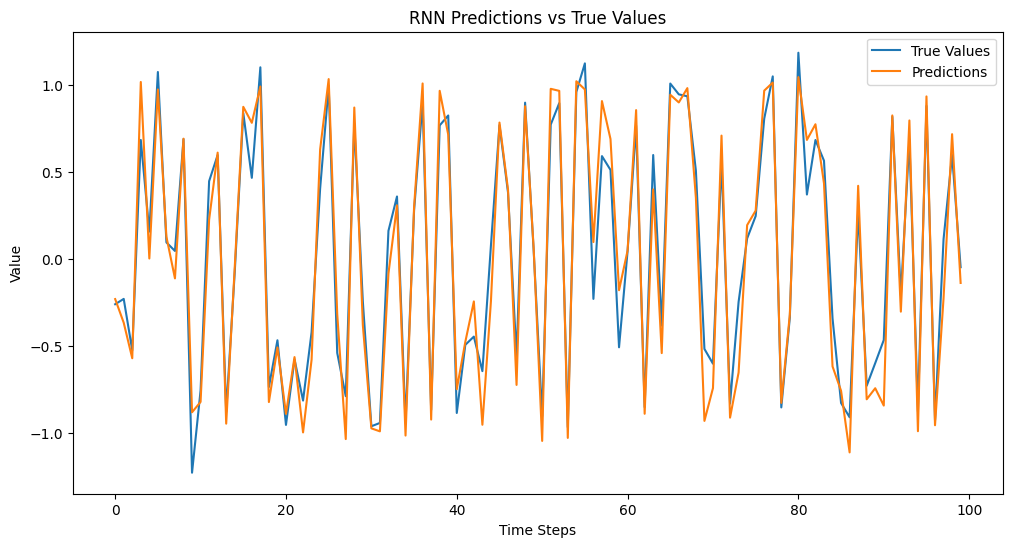

In [8]:
if __name__ == "__main__":
    main()